In [3]:
# Librerías

# Manejo de archivos
import numpy as np
from scipy.ndimage import gaussian_filter

# Matemáticas
import os
from imutils import paths

# Gráficas e imágenes
import cv2
import matplotlib.pyplot as plt

# Para modelo de Deep Learning
import tensorflow as tf
import tensorflow_addons as tfa
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from keras.layers import (
    Dense, 
    Input, 
    Multiply, 
    Concatenate, 
    LSTM, 
    RepeatVector, 
    TimeDistributed, 
    Flatten, 
    RandomFlip,
    UpSampling2D,
    Conv2D,
    Conv2DTranspose,
    MaxPool2D,
    AveragePooling2D,
    BatchNormalization)
from numpy import asarray
from matplotlib import pyplot
from tensorflow.keras.applications import VGG16
from keras.losses import mse
from tensorflow.data import AUTOTUNE


In [6]:
# Adquisición de datos para entrenamiento del modelo 

# Abrir la dirección donde se encuentran las imágenes
src_path = "cells" 

# Guardar las direcciones de imágenes y sus mapas de densidad en listas
img_paths = []
labels_paths = []

all_paths = list(paths.list_images(src_path))

for path in all_paths:
    flag = path.split("\\")[1][3:].split(".")[0]
    
    if flag == "cell":
        img_paths.append(path)
        
    else:
        labels_paths.append(path)

# Compilar toda la información en una lista

data= []

for i in range(len(img_paths)):
    #[path de imagen, path de labels]
    data.append([img_paths[i],labels_paths[i]])
    
#Toda la información del dataset se concentra en la variable data, que contiene paths
#de las imágenes correspondientes a microscopías y anotaciones de la ubicación
#de las células en forma de imagen. Ambas imágenes se encuentran en formato png.
print(data[0])

['cells\\001cell.png', 'cells\\001dots.png']


(-0.5, 255.5, 255.5, -0.5)

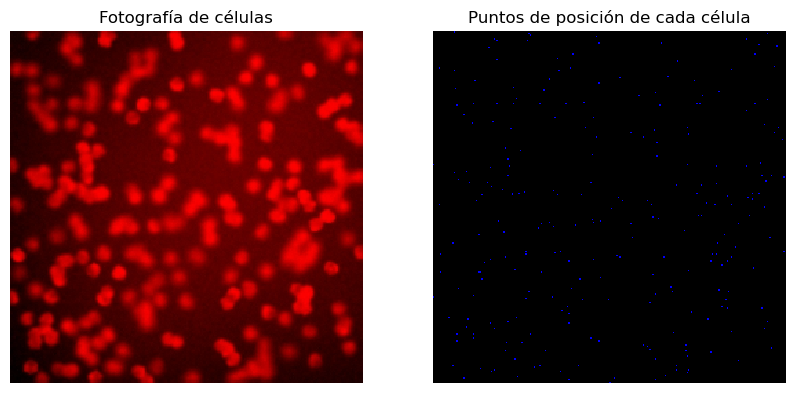

In [7]:
# Ejemplo para leer las imágenes.

# Índice aleatorio
idx = np.random.randint(0,len(data))

# Leer fotografía de células y label
cell = cv2.imread(data[idx][0])/255
dmap = cv2.imread(data[idx][1])/255

# Graficar
fig = plt.figure(figsize=(10, 7))

filas = 1
columnas = 2

fig.add_subplot(filas, columnas, 1)
plt.imshow(cell ,cmap='hot', interpolation='nearest')
plt.title("Fotografía de células")
plt.axis("off")

fig.add_subplot(filas, columnas, 2)
plt.imshow(dmap ,cmap='hot', interpolation='nearest')
plt.title("Puntos de posición de cada célula")
plt.axis("off")

In [8]:
#Función para obtener los tensores para el modelo.
import tensorflow as tf
import tensorflow_addons as tfa
import cv2

def load_data(data, shape):
    # Leamos la imagen, decodificarla, convertir el tipo de datos a float32, y redimensionar la imagen
    # Esto resulta en una imagen de nxm dimensiones y tres canales. (n,m,3)
    img = tf.io.read_file(data[0])
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32) # int-8 --> float32
    img = tf.image.resize(img, shape)

    # Extraer la imagen de labels. Esto resulta en una imagen de nxm dimensiones y un canal. (n,m,1)
    label1 = tf.io.read_file(data[1])
    label1 = tf.image.decode_png(label1, channels=1)
    #label = tf.image.resize(label, shape)
    label1 = (label1/tf.math.reduce_max(label1))*100
    #label1 = gaussian_filter(label1, sigma=(5, 5, 1), order=0)
    label1 = tfa.image.gaussian_filter2d(label1, sigma = [2,2])
    label1 = tf.image.resize(label1, shape)
    
    # Integrar la función de densidad de probabilidades. Esto resulta en un escalar.
    label2 = tf.math.reduce_sum(label1)/100
    
    
    return img, label1 #, label2 #label1#, label2

In [9]:
def load_img(data, shape):
    # Leamos la imagen, decodificarla, convertir el tipo de datos a float32, y redimensionar la imagen
    # Esto resulta en una imagen de nxm dimensiones y tres canales. (n,m,3)
    img = tf.io.read_file(data[0])
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32) # int-8 --> float32
    img = tf.image.resize(img, shape)
    
    return img

In [10]:
def load_y1(data, shape):
    # Extraer la imagen de labels. Esto resulta en una imagen de nxm dimensiones y un canal. (n,m,1)
    label1 = tf.io.read_file(data[1])
    label1 = tf.image.decode_png(label1, channels=1)
    #label = tf.image.resize(label, shape)
    label1 = (label1/tf.math.reduce_max(label1))*100
    #label1 = gaussian_filter(label1, sigma=(5, 5, 1), order=0)
    label1 = tfa.image.gaussian_filter2d(label1, sigma = (10,10))
    label1 = tf.image.resize(label1, shape)
    
    return label1

In [11]:
def load_y2(data, shape):
    
    label1 = load_y1(data, shape)
    
     # Integrar la función de densidad de probabilidades. Esto resulta en un escalar.
    label2 = tf.math.reduce_sum(label1)/100
    label2 = tf.reshape(label2, [1])
    
    return label2

In [12]:
#Uso de callbacks
from keras import callbacks
chkp_path  = "PAP//PAP Machine Learning//Checkpoints\\"

my_Checkpoint = callbacks.ModelCheckpoint(
    chkp_path, #filepath
    save_weights_only = True, #sólo guarda los pesos del modelo
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
     )

my_earlystopping = callbacks.EarlyStopping(
    monitor = "loss",
    min_delta = 0.04, #Cambio mínimo
    patience = 3, #Cuántas épocas esperará antes de detenerse si no ve mejora
    
    )

In [117]:
#split de datos
#Separación en train y test
from sklearn.model_selection import train_test_split

total_data, void_data = train_test_split(data, test_size=0.01, random_state=42)

train_data, test_data = train_test_split(data, test_size=0.33, random_state=42)

train_data, val_data = train_test_split(train_data, test_size=0.33, random_state=42)

In [135]:
#Generador de datos para el modelo. Este carga porciones del dataset para no tener 
#todas las imágenes en memoria.
from tensorflow.data import AUTOTUNE

batch_size = 4
shape = (256,256)

total_dataset = tf.data.Dataset.from_tensor_slices(total_data)
total_dataset =  (total_dataset
                 .shuffle(len(total_data))
                 .map(lambda x: load_data(x,shape), num_parallel_calls=AUTOTUNE)
                 .cache()
                 .batch(batch_size)
                 .prefetch(AUTOTUNE)
                 )
    

train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = (train_dataset
                 .shuffle(len(train_data))
                 .map(lambda x: load_data(x,shape), num_parallel_calls=AUTOTUNE)
                 .cache()
                 .batch(batch_size)
                 .prefetch(AUTOTUNE)
                 )
    
val_dataset = tf.data.Dataset.from_tensor_slices(val_data)
val_dataset = (val_dataset
               .shuffle(len(val_data))
               .map(lambda x: load_data(x, shape), num_parallel_calls=AUTOTUNE)
               .cache()
               .batch(batch_size)
               .prefetch(AUTOTUNE)
               )


test_dataset = tf.data.Dataset.from_tensor_slices(test_data)
test_dataset = (test_dataset
                 .map(lambda x: load_data(x, shape), num_parallel_calls=AUTOTUNE)
                 .cache()
                 .batch(batch_size)
                 .prefetch(AUTOTUNE)
                 )

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_345 (Conv2D)            (None, 254, 254, 32  896         ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_346 (Conv2D)            (None, 252, 252, 32  9248        ['conv2d_345[0][0]']             
                                )                                                          

                                                                                                  
 conv2d_transpose_90 (Conv2DTra  (None, 213, 213, 64  8256       ['conv2d_362[0][0]']             
 nspose)                        )                                                                 
                                                                                                  
 tf.image.resize_63 (TFOpLambda  (None, 217, 217, 64  0          ['conv2d_transpose_90[0][0]']    
 )                              )                                                                 
                                                                                                  
 add_60 (Add)                   (None, 217, 217, 64  0           ['conv2d_360[0][0]',             
                                )                                 'tf.image.resize_63[0][0]']     
                                                                                                  
 conv2d_36

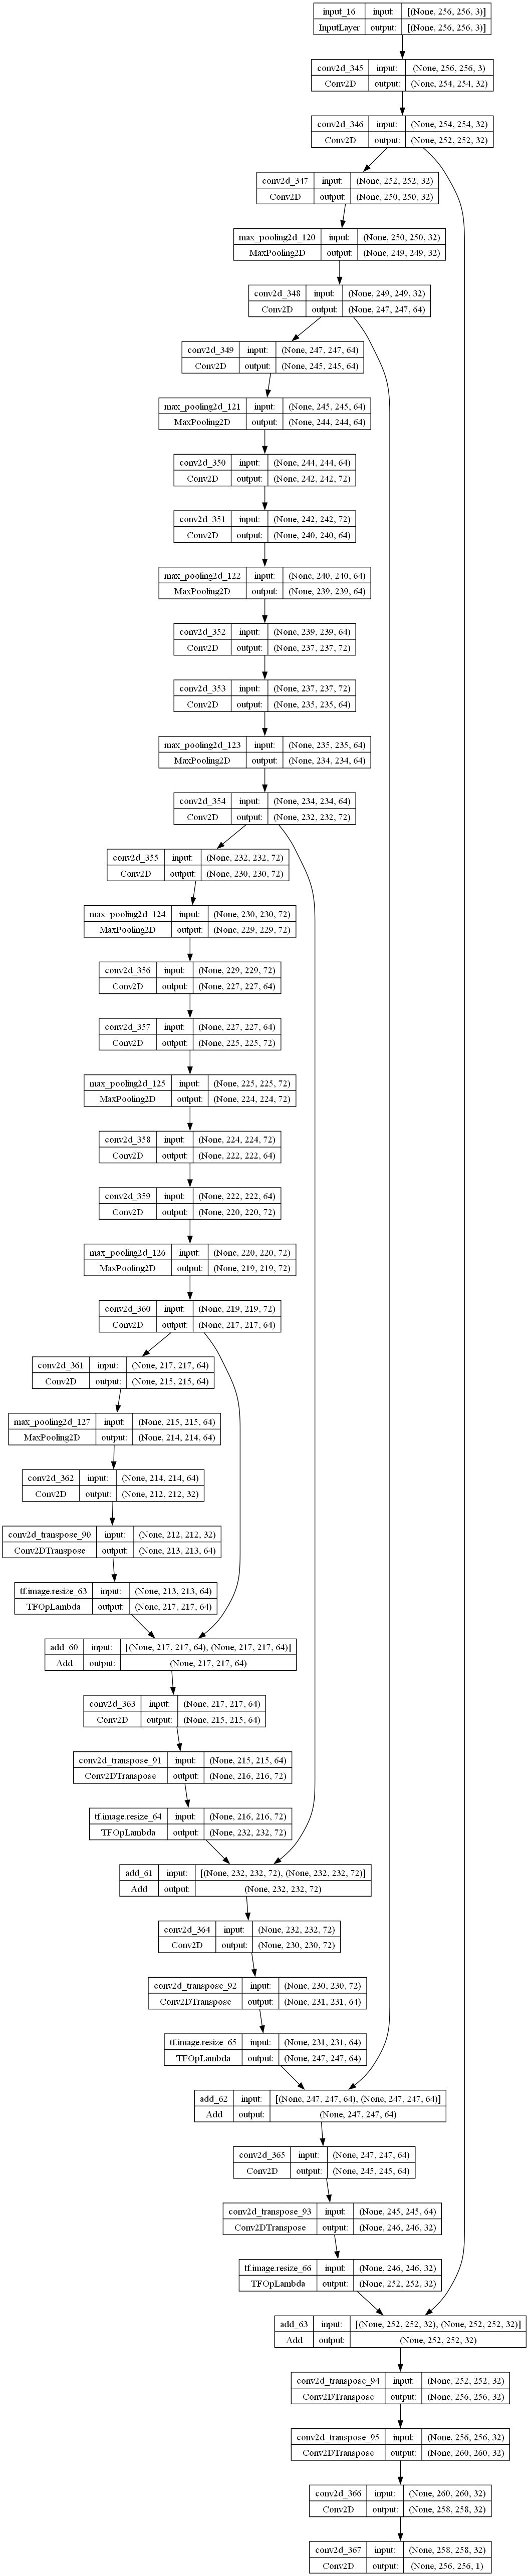

In [124]:
#Modelo 3 . resolución 256x256. Función de pérdida MAE. Basado en U-Net

#Modelo
import tensorflow as tf
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from keras.layers import (
    Dense, 
    Input, 
    Multiply, 
    Add,
    Concatenate, 
    LSTM, 
    RepeatVector, 
    TimeDistributed, 
    Flatten, 
    RandomFlip,
    UpSampling2D,
    Conv2D,
    Conv2DTranspose,
    MaxPool2D,
    AveragePooling2D,
    BatchNormalization)
from numpy import asarray
from matplotlib import pyplot
from tensorflow.keras.applications import VGG16
from keras.losses import mse

shape = (256,256)
img = load_img(data[0], shape)
label1 = load_y1(data[0], shape)

n_x = np.array(img).shape
n_y1 = np.array(label1).shape


k = 2
fi = 4
f1 = 32
f2 = 64
f3 = 72
f4 = 64
f5 = 32

#Datos
xi = Input(shape = n_x)

x_o1 = Conv2D(filters=f1, kernel_size=(3,3), strides=(1,1), activation='relu')(xi)
x_o1 = Conv2D(filters=f1, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)

x_o2 = Conv2D(filters=f1, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)
x_o2 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o2)
x_o2 = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o2)
#x_o2 = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o2)

x_o3 = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o2)
x_o3 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o3)
x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
#x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)

x_o3 = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
x_o3 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o3)
x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
#x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)

x_o3 = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
x_o3 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o3)
x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
#x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)

x_o4 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
x_o4 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o4)
x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
#x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)

x_o4 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
x_o4 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o4)
x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
#x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)

x_o4 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
x_o4 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o4)
x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
#x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)

x_o5 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
x_o5 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o5)
x_o5 = Conv2D(filters=f5, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o5)
#x_o5 = Conv2D(filters=f5, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o5)
x_o5 = Conv2DTranspose(filters=f4, kernel_size=(2,2), strides=(1,1), activation='relu')(x_o5)
x_o5 = tf.image.resize(x_o5,size = (x_o4.shape[1],x_o4.shape[2]))

x_o4 = Add()([x_o4, x_o5]) 
x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
#x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
x_o4 = Conv2DTranspose(filters=f3, kernel_size=(2,2), strides=(1,1), activation='relu')(x_o4)
x_o4 = tf.image.resize(x_o4,size = (x_o3.shape[1],x_o3.shape[2]))

x_o3 = Add()([x_o3, x_o4]) 
x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
#x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
x_o3 = Conv2DTranspose(filters=f2, kernel_size=(2,2), strides=(1,1), activation='relu')(x_o3)
x_o3 = tf.image.resize(x_o3,size = (x_o2.shape[1],x_o2.shape[2]))

x_o2 = Add()([x_o2, x_o3]) 
x_o2 = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o2)
#x_o2 = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o2)
x_o2 = Conv2DTranspose(filters=f1, kernel_size=(2,2), strides=(1,1), activation='relu')(x_o2)
x_o2 = tf.image.resize(x_o2,size = (x_o1.shape[1],x_o1.shape[2]))

x_o1 = Add()([x_o1, x_o2]) 
x_o1 = Conv2DTranspose(filters=f1, kernel_size=(5,5), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2DTranspose(filters=f1, kernel_size=(5,5), strides=(1,1), activation='relu')(x_o1)
#x_o1 = Conv2DTranspose(filters=f1, kernel_size=(4,4), strides=(1,1), activation='relu')(x_o1)

#x_o1 = Conv2D(filters=f1, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2D(filters=f1, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)


x_o = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)


model3 = Model(inputs = [xi], outputs = [x_o])

model3.compile(loss="MSE",
    optimizer='adam', 
    metrics=["accuracy"])

# Mostrar datos y arquitectura del modelo
model3.summary()

    #return model
    
plot_model(model3, show_shapes = True)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_322 (Conv2D)            (None, 254, 254, 32  896         ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_323 (Conv2D)            (None, 252, 252, 32  9248        ['conv2d_322[0][0]']             
                                )                                                          

                                                                                                  
 conv2d_transpose_84 (Conv2DTra  (None, 213, 213, 64  8256       ['conv2d_339[0][0]']             
 nspose)                        )                                                                 
                                                                                                  
 tf.image.resize_58 (TFOpLambda  (None, 217, 217, 64  0          ['conv2d_transpose_84[0][0]']    
 )                              )                                                                 
                                                                                                  
 add_56 (Add)                   (None, 217, 217, 64  0           ['conv2d_337[0][0]',             
                                )                                 'tf.image.resize_58[0][0]']     
                                                                                                  
 conv2d_34

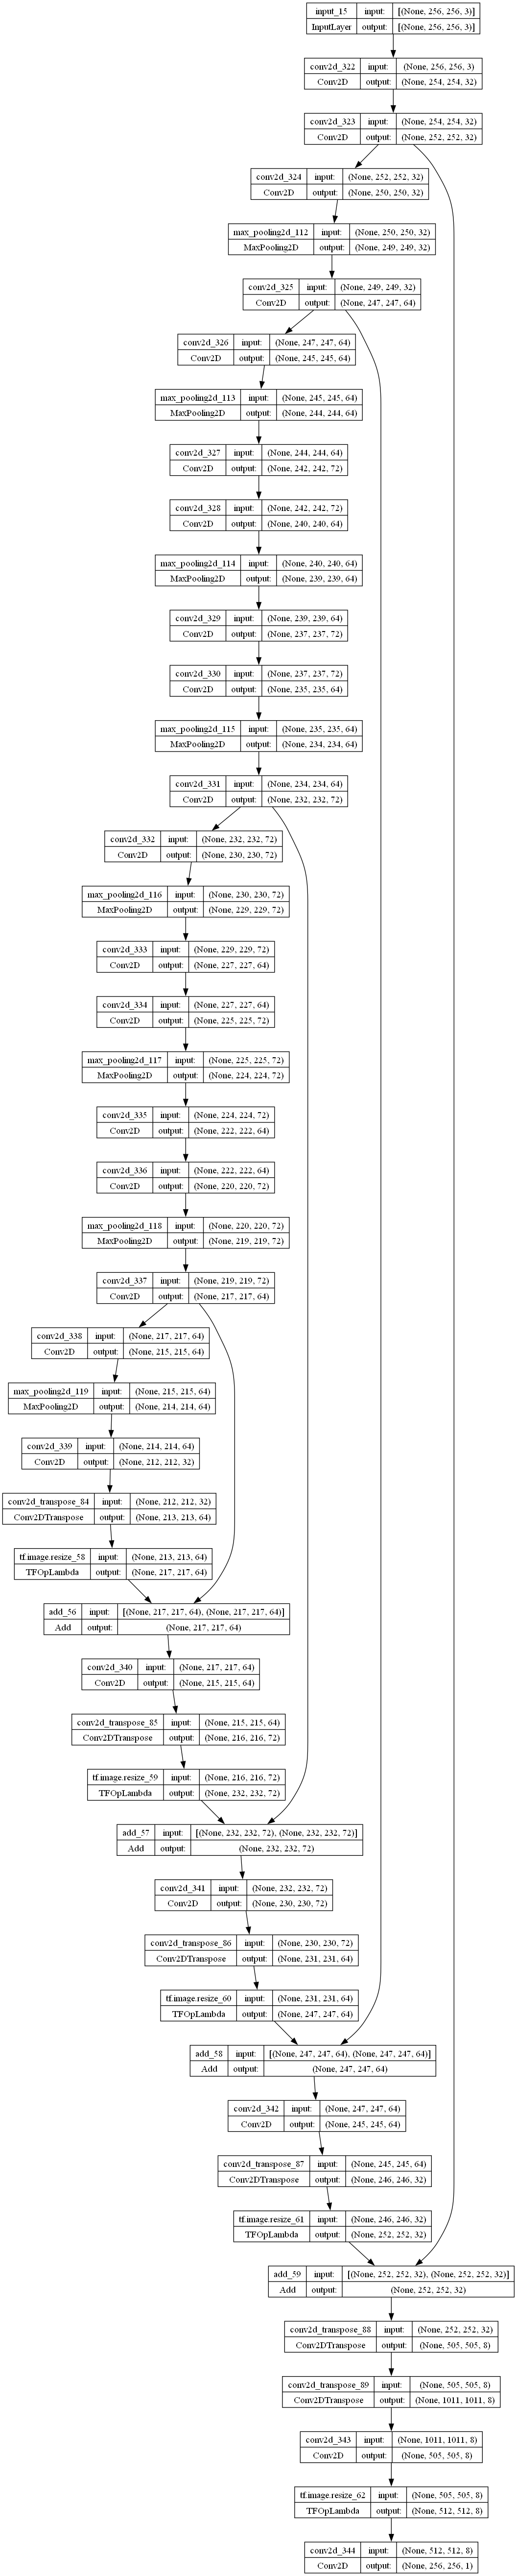

In [94]:
#Modelo 3 . resolución 256x256. Función de pérdida MAE. Basado en U-Net

#Modelo
import tensorflow as tf
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from keras.layers import (
    Dense, 
    Input, 
    Multiply, 
    Add,
    Concatenate, 
    LSTM, 
    RepeatVector, 
    TimeDistributed, 
    Flatten, 
    RandomFlip,
    UpSampling2D,
    Conv2D,
    Conv2DTranspose,
    MaxPool2D,
    AveragePooling2D,
    BatchNormalization)
from numpy import asarray
from matplotlib import pyplot
from tensorflow.keras.applications import VGG16
from keras.losses import mse

shape = (256,256)
img = load_img(data[0], shape)
label1 = load_y1(data[0], shape)

n_x = np.array(img).shape
n_y1 = np.array(label1).shape


k = 2
fi = 4
f1 = 32
f2 = 64
f3 = 72
f4 = 64
f5 = 32

#Datos
xi = Input(shape = n_x)

x_o1 = Conv2D(filters=f1, kernel_size=(3,3), strides=(1,1), activation='relu')(xi)
x_o1 = Conv2D(filters=f1, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)

x_o2 = Conv2D(filters=f1, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)
x_o2 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o2)
x_o2 = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o2)
#x_o2 = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o2)

x_o3 = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o2)
x_o3 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o3)
x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
#x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)

x_o3 = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
x_o3 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o3)
x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
#x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)

x_o3 = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
x_o3 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o3)
x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
#x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)

x_o4 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
x_o4 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o4)
x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
#x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)

x_o4 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
x_o4 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o4)
x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
#x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)

x_o4 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
x_o4 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o4)
x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
#x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)

x_o5 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
x_o5 = MaxPool2D(pool_size=(2,2), strides = 1)(x_o5)
x_o5 = Conv2D(filters=f5, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o5)
#x_o5 = Conv2D(filters=f5, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o5)
x_o5 = Conv2DTranspose(filters=f4, kernel_size=(2,2), strides=(1,1), activation='relu')(x_o5)
x_o5 = tf.image.resize(x_o5,size = (x_o4.shape[1],x_o4.shape[2]))

x_o4 = Add()([x_o4, x_o5]) 
x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
#x_o4 = Conv2D(filters=f4, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o4)
x_o4 = Conv2DTranspose(filters=f3, kernel_size=(2,2), strides=(1,1), activation='relu')(x_o4)
x_o4 = tf.image.resize(x_o4,size = (x_o3.shape[1],x_o3.shape[2]))

x_o3 = Add()([x_o3, x_o4]) 
x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
#x_o3 = Conv2D(filters=f3, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
x_o3 = Conv2DTranspose(filters=f2, kernel_size=(2,2), strides=(1,1), activation='relu')(x_o3)
x_o3 = tf.image.resize(x_o3,size = (x_o2.shape[1],x_o2.shape[2]))

x_o2 = Add()([x_o2, x_o3]) 
x_o2 = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o2)
#x_o2 = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o2)
x_o2 = Conv2DTranspose(filters=f1, kernel_size=(2,2), strides=(1,1), activation='relu')(x_o2)
x_o2 = tf.image.resize(x_o2,size = (x_o1.shape[1],x_o1.shape[2]))

x_o1 = Add()([x_o1, x_o2]) 
x_o1 = Conv2DTranspose(filters=8, kernel_size=(3,3), strides=(2,2), activation='relu')(x_o1)
x_o1 = Conv2DTranspose(filters=8, kernel_size=(3,3), strides=(2,2), activation='relu')(x_o1)
#x_o1 = Conv2DTranspose(filters=f1, kernel_size=(4,4), strides=(1,1), activation='relu')(x_o1)

#x_o1 = Conv2D(filters=f1, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2D(filters=8, kernel_size=(2,2), strides=(2,2), activation='relu')(x_o1)
x_o1 = tf.image.resize(x_o1,size = (512,512))


x_o = Conv2D(filters=1, kernel_size=(2,2), strides=(2,2), activation='relu')(x_o1)


model4 = Model(inputs = [xi], outputs = [x_o])

model4.compile(loss="MSE",
    optimizer='adam', 
    metrics=["accuracy"])

# Mostrar datos y arquitectura del modelo
model4.summary()

    #return model
    
plot_model(model4, show_shapes = True)

#MOdelo 2. resolución 256x256

#Modelo
import tensorflow as tf
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from keras.layers import (
    Dense, 
    Input, 
    Multiply, 
    Concatenate, 
    LSTM, 
    RepeatVector, 
    TimeDistributed, 
    Flatten, 
    RandomFlip,
    UpSampling2D,
    Conv2D,
    Conv2DTranspose,
    MaxPool2D,
    AveragePooling2D,
    BatchNormalization)
from numpy import asarray
from matplotlib import pyplot
from tensorflow.keras.applications import VGG16
from keras.losses import mse

shape = (256,256)
img = load_img(data[0], shape)
label1 = load_y1(data[0], shape)

n_x = np.array(img).shape
n_y1 = np.array(label1).shape


#Datos
xi = Input(shape = n_x)

x_o1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu')(xi)
x_o1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)
x_o1 = MaxPool2D(pool_size=(2,2),strides=1)(x_o1)

x_o3_1 = x_o1

x_o1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),activation='relu')(x_o1)


x_o1 = MaxPool2D(pool_size=(2,2),strides=1)(x_o1)

x_o1 = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2DTranspose(filters=128, kernel_size=(2,2), strides=(1,1), activation='relu')(x_o1)
#x_o1 = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)
#x_o1 = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)
#x_o1 = Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), activation='relu')(x_o1)

x_o3_2 = x_o1
x_o3 = Multiply()([x_o3_1,x_o3_2])

x_o1 = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o3)
x_o1 = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)



x_o2 = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(xi)
x_o2 = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o2)
x_o2 = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o2)
x_o2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o2)
x_o2 = Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), activation='relu')(x_o2)
#x_o2 = Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), activation='relu')(x_o2)




#Outputs

x_o1 = Multiply()([x_o1,x_o2])
x_o1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2D(filters=64, kernel_size=(2,2), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), activation='relu')(x_o1)



model2 = Model(inputs = [xi], outputs = [x_o1])

model2.compile(loss="MSE",
    optimizer='adam', 
    metrics=["accuracy"])

# Mostrar datos y arquitectura del modelo
model2.summary()

    #return model
    
plot_model(model2, show_shapes = True)

#MOdelo 2. resolución 256x256

#Modelo
import tensorflow as tf
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from keras.layers import (
    Dense, 
    Input, 
    Multiply, 
    Concatenate, 
    LSTM, 
    RepeatVector, 
    TimeDistributed, 
    Flatten, 
    RandomFlip,
    UpSampling2D,
    Conv2D,
    Conv2DTranspose,
    MaxPool2D,
    AveragePooling2D,
    BatchNormalization)
from numpy import asarray
from matplotlib import pyplot
from tensorflow.keras.applications import VGG16
from keras.losses import mse

shape = (256,256)
img = load_img(data[0], shape)
label1 = load_y1(data[0], shape)

n_x = np.array(img).shape
n_y1 = np.array(label1).shape


#Datos
xi = Input(shape = n_x)
xi = RandomFlip()(xi)


x_o1 = Conv2D(filters=256, kernel_size=(2,2), strides=(2,2), activation='relu')(xi)
x_o1 = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), activation='relu')(x_o1)

x_o3_1 = x_o1

x_o1 = MaxPool2D(pool_size=(4,4),strides=1)(x_o1)

x_o1 = Conv2D(filters=256, kernel_size=(4,4), strides=(2,2), activation='relu')(x_o1)
x_o1 = Conv2D(filters=128, kernel_size=(4,4), strides=(2,2),activation='relu')(x_o1)


x_o1 = MaxPool2D(pool_size=(3,3),strides=2)(x_o1)

x_o1 = Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu')(x_o1)
x_o1 = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), activation='relu')(x_o1)
x_o1 = Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu')(x_o1)
x_o1 = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2DTranspose(filters=64, kernel_size=(4,4), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(1,1), activation='relu')(x_o1)

x_o3_2 = x_o1
x_o3 = Multiply()([x_o3_1,x_o3_2])

x_o1 = Conv2DTranspose(filters=32, kernel_size=(4,4), strides=(2,2), activation='relu')(x_o3)
x_o1 = Conv2DTranspose(filters=1, kernel_size=(2,2), strides=(2,2), activation='relu')(x_o1)




x_o2 = Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu')(xi)
x_o2 = Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu')(x_o2)




#Outputs

x_o1 = Multiply()([x_o1,x_o2])
x_o1 = Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), activation='relu')(x_o1)
x_o1 = Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), activation='relu')(x_o1)



model2 = Model(inputs = [xi], outputs = [x_o1])

model2.compile(loss="MSE",
    optimizer='adam', 
    metrics=["accuracy"])

# Mostrar datos y arquitectura del modelo
model2.summary()

    #return model
    
plot_model(model2, show_shapes = True)

In [ ]:
#def get_raw_data(data, shape, data_type):
#    
#    temp = []
#    
#    for i in range(len(data)):
#        if data_type == "img":
#            temp.append(load_img(data[i], shape))
#        elif data_type == "y1":
#            temp.append(load_y1(data[i], shape))
#        elif data_type == "y2":
#            temp.append(load_y2(data[i], shape))
#        else:
#            pass
#    temp = np.array(temp)
#    
#    return temp

In [ ]:
#shape = (256,256)
#imgs = get_raw_data(data, shape, "img")
#y1s = get_raw_data(data, shape, "y1")
#y2s = get_raw_data(data, shape, "y2")


In [125]:
h = model3.fit(train_dataset,  
              epochs = 40,
              validation_data = val_dataset,
              #validation_split = 0.3,
              callbacks = [my_Checkpoint, my_earlystopping])

Epoch 1/40
23/23 [==============================] - 10s 342ms/step - loss: 2.8960 - accuracy: 0.7669 - val_loss: 2.3755 - val_accuracy: 0.8045
Epoch 2/40
23/23 [==============================] - 7s 319ms/step - loss: 2.4282 - accuracy: 0.8482 - val_loss: 2.0163 - val_accuracy: 0.8864
Epoch 3/40
23/23 [==============================] - 7s 318ms/step - loss: 1.9334 - accuracy: 0.9069 - val_loss: 1.6582 - val_accuracy: 0.9286
Epoch 4/40
23/23 [==============================] - 7s 321ms/step - loss: 1.6704 - accuracy: 0.9324 - val_loss: 1.4882 - val_accuracy: 0.9391
Epoch 5/40
23/23 [==============================] - 7s 320ms/step - loss: 1.5715 - accuracy: 0.9374 - val_loss: 1.4682 - val_accuracy: 0.9471
Epoch 6/40
23/23 [==============================] - 7s 320ms/step - loss: 1.4659 - accuracy: 0.9387 - val_loss: 1.3951 - val_accuracy: 0.9531
Epoch 7/40
23/23 [==============================] - 7s 321ms/step - loss: 1.4013 - accuracy: 0.9417 - val_loss: 1.3254 - val_accuracy: 0.9451
Epoch

In [136]:
b1 = model3.predict(total_dataset)
x1s = []
y1s = []

mm = [i for i in total_dataset]

for i in range(len(mm)):
    for j in range(len(mm[i][1])):
        y1s.append(mm[i][1][j])
        
nn = [i for i in test_dataset]
        

for i in range(len(nn)):
    for j in range(len(nn[i][0])):
        x1s.append(mm[i][0][j])
        

preds2 = [np.sum(b1[i])/100 for i in range(len(b1))]
reals2 = [np.sum(y1s[i])/100 for i in range(len(y1s))]

50/50 [==============================] - 5s 89ms/step


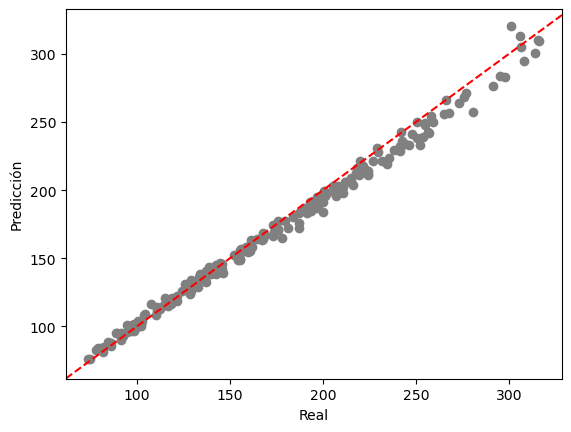

In [137]:
plt.scatter(reals2, preds2, c = "gray")
plt.ylabel("Predicción")
plt.xlabel("Real")
plt.axline((np.min(reals2),np.min(reals2)),slope=1,linestyle='--',color='r')

plt.show()

IndexError: list index out of range

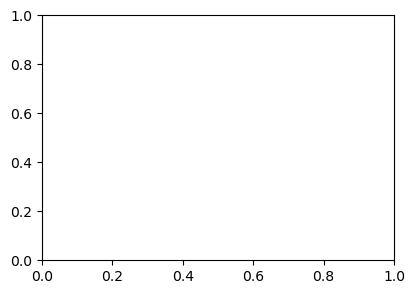

In [138]:
idx = np.random.randint(0,len(b1))

# Graficar
fig = plt.figure(figsize=(10, 7))

filas = 2
columnas = 2

fig.add_subplot(filas, columnas, 1)
plt.imshow(x1s[idx])
plt.title("Imagen #"+str(idx))
plt.axis("off")
#plt.show()

fig.add_subplot(filas, columnas, 2)
plt.imshow(b1[idx], cmap='hot', interpolation='nearest')
#Gráficashot', interpolation='nearest')
plt.title("PREDICCIÓN.Imágen #"+str(idx))
plt.axis("off")
#plt.show()
    
fig.add_subplot(filas, columnas, 3)
plt.imshow(y1s[idx], cmap='hot', interpolation='nearest')
plt.title("REAL. Label #"+str(idx))
plt.axis("off")
#plt.show()

print(np.round(np.sum(b1[idx])/100,0), np.round(np.sum(y1s[idx])/100,0))

In [130]:
# guardar pesos del modelo

path = "cells//checkpoints"

#model3.save_weights(path)

# cargar pesos del modelo

#model3.load_weights(path)



In [131]:
# guardar modelo
path = "cells//models"

model3.save(path)

#model3.load(path)

INFO:tensorflow:Assets written to: cells//models\assets


INFO:tensorflow:Assets written to: cells//models\assets


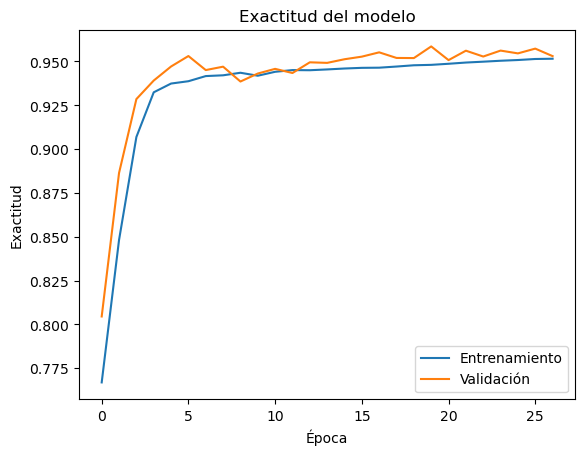

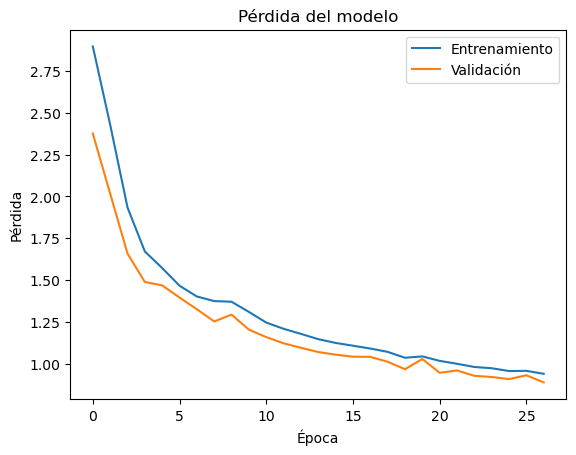

In [148]:
# summarize history for accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='best')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='best')
plt.show()

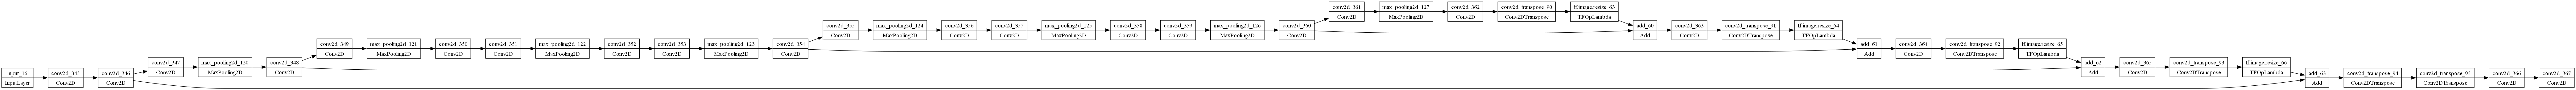

In [150]:
tf.keras.utils.plot_model(
    model3,
    to_file="model3.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

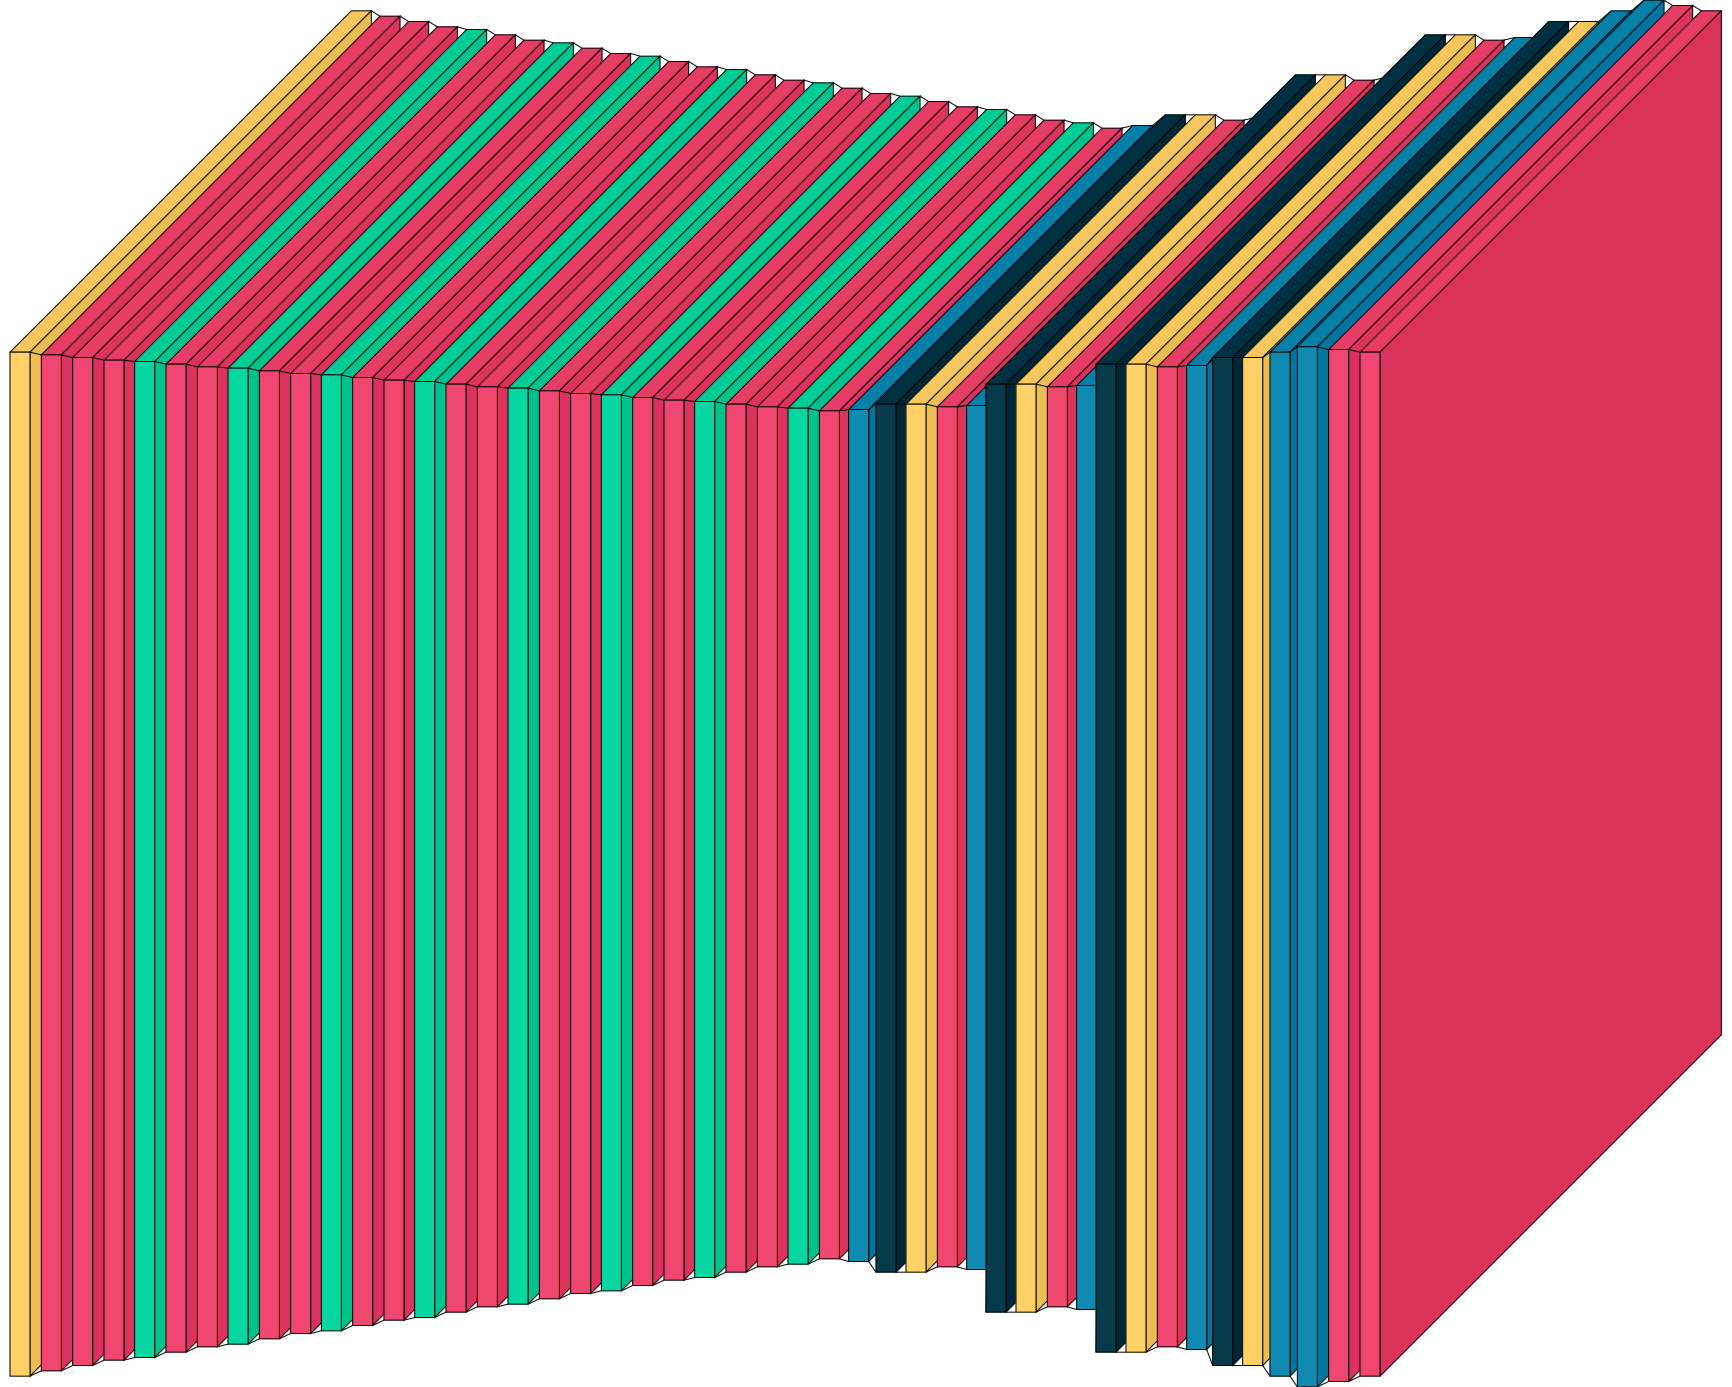

In [153]:
import visualkeras
visualkeras.layered_view(model3)